In [1]:
# environment: labelmaker

# (2) 1. InternImage: I had to install:
        # pip install -U openmim
        # mim install mmsegmentation==0.27.0
    # because I got an error, and followed the suggestions here: https://github.com/OpenGVLab/InternImage/issues/208

# (3) 2. OVSeg: I had to do:
        # export PYTHONPATH=$PYTHONPATH:~/Desktop/LabelMaker # because some code used as "package" (from labelmaker.label_data import get_ade150, get_replica, get_wordnet) was in the GitHub repository of LabelMaker
    # I also had to install CLIP following these instructions, with some modifications: https://github.com/facebookresearch/ov-seg/blob/2a3a047973f9db3d3695d01098351f251ffc362e/INSTALL.md :
        # python -m pip install -U setuptools # got setuptools-70.0.0
        # cd third_party/CLIP # of the ov-seg GitHub repository
        # python -m pip install -Ue . # to install CLIP

# (4) 3. 

# (1) 5. Mask3D: environment as provided by the LabelMaker GitHub page (installation done a bit differently, however. See the txt file I created)

In [20]:
import open3d as o3d
import os
import numpy as np
import scannet200_constants
import matplotlib.pyplot as plt

## LabelMaker - 0. Preparation

### ARKitScenes

If you want to download something from ARKitScenes (https://github.com/apple/ARKitScenes/tree/095a1190748be2c62d3f70f211352a31eac0172c?tab=readme-ov-file), I found the list of IDs of the scenes that can be used here: https://github.com/apple/ARKitScenes/blob/095a1190748be2c62d3f70f211352a31eac0172c/raw/raw_train_val_splits.csv

Additional information are here: https://github.com/apple/ARKitScenes/blob/095a1190748be2c62d3f70f211352a31eac0172c/DATA.md

First of all, one needs to download the ARKitScenes. **The following code has to be executed in the CMD, being in the root of the clone of the GitHub repository of LabelMaker**:

```bash
#
# Download scene
#
export TRAINING_OR_VALIDATION=Training
export SCENE_ID=47333462 # TODO TOSET: change with what you need

conda activate labelmaker

python 3rdparty/ARKitScenes/download_data.py raw --split $TRAINING_OR_VALIDATION --video_id $SCENE_ID --download_dir ~/Desktop/LabelMaker/ARKitScenes/ --raw_dataset_assets lowres_depth confidence lowres_wide.traj lowres_wide lowres_wide_intrinsics vga_wide vga_wide_intrinsics # TODO TOSET: in case change the paths and the things to be downloaded

#
# Convert scene to LabelMaker workspace
#

WORKSPACE_DIR=~/Desktop/LabelMaker/workspace/$SCENE_ID # TODO TOSET: change the path, in case

python scripts/arkitscenes2labelmaker.py --scan_dir ~/Desktop/LabelMaker/ARKitScenes/raw/$TRAINING_OR_VALIDATION/$SCENE_ID --target_dir $WORKSPACE_DIR # TODO TOSET: change the path, in case
```
	
	
In my case, I will find the things to work with in this directory: `/local/home/gmarsich/Desktop/LabelMaker/workspace/`

Then, to visualise the point cloud obtained after having used `scripts/arkitscenes2labelmaker.py`:

In [3]:
scene_id_num = 47333462 # TODO TOSET: change if needed
scene_id = str(scene_id_num)

# Show the original point cloud
pcd_original = o3d.io.read_point_cloud(os.path.join('/local/home/gmarsich/Desktop/LabelMaker/workspace', scene_id, 'mesh.ply')) # TODO TOSET: change the name of the point cloud to open
o3d.visualization.draw_geometries([pcd_original])

## LabelMaker - 1. InternImage

This part performs semantic segmentation using the InternImage model. *For an image of the ARKitScenes may take something like $1$ h and $30$ min.*

**The following code has to be executed in the CMD, being in the root of the clone of the GitHub repository of LabelMaker**:

```bash
conda activate labelmaker

export WORKSPACE_DIR=/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes/47333462

python models/internimage.py --workspace $WORKSPACE_DIR
```

For each input image in the color subdirectory of the workspace, the script generates a segmentation result. The segmentation result is a labeled image where each pixel's value corresponds to a class label. The segmentation results are saved as PNG images in the output directory. Each output file has the same base name as the corresponding input file, but with a `.png` extension. The segmentation result images are saved in a format where the pixel values represent class labels. The pixel values are stored as 16-bit unsigned integers (`np.uint16`).

So, to understand the output (structure of the code taken from: https://github.com/cvg/LabelMaker/blob/main/notebooks/evaluation_labelmaker.ipynb):

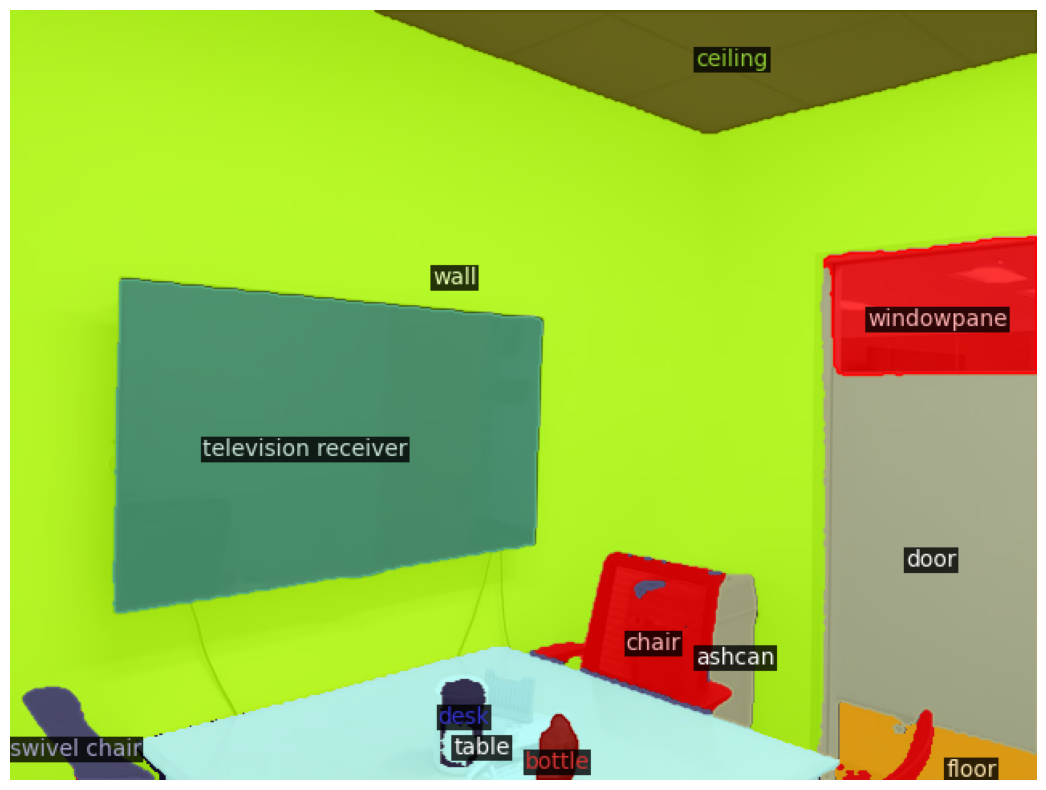

In [19]:
# TODO: set colors so that they are no more random

import cv2
from labelmaker.visualisation import draw_sem_seg, VisImage
from labelmaker.label_data import get_ade150

path_dir_img_color = '/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes/40753679/color' #TODO TOSET
img_color_key = '000000' #TODO TOSET
img = cv2.imread(f'{path_dir_img_color}/{img_color_key}.jpg')[..., ::-1]

dir_internimage = '/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes/40753679/intermediate/ade20k_internimage_1' # TODO TOSET
intern = cv2.imread(f'{dir_internimage}/{img_color_key}.png',
                    cv2.IMREAD_UNCHANGED)

vis = VisImage(img, scale=1)
draw_sem_seg(
    intern,
    vis,
    classes=[x['name'] for x in sorted(get_ade150(), key=lambda x: x['id'])])
plt.figure(figsize=(20, 10))
plt.imshow(vis.get_image())
plt.gca().axis('off')

plt.show()

## LabelMaker - 2. OVSeg

*For an image of the ARKitScenes may take something like $2$ h.*

Had to run:

```bash
python models/ovseg.py --workspace ~/data2TB/LabelMaker/processed_ARKitScenes/40753679
```

because using ```export WORKSPACE_DIR=~/data2TB/LabelMaker/processed_ARKitScenes/40753679``` did not work.

## LabelMaker - 5. Mask3D

Type of object, colour and ID in the segmentation respect the indications specified in this file: https://github.com/ScanNet/ScanNet/blob/master/BenchmarkScripts/ScanNet200/scannet200_constants.py

Now we want to perform the segmentation with Mask3D, that is also a part of the pipeline of LabelMaker. **The following code has to be executed in the CMD, being in the root of the clone of the GitHub repository of LabelMaker**:

IMPORTANT: the script will search for a file named `mesh.ply` in the `WORKSPACE_DIR`, so rename the file accordingly

```bash
conda activate labelmaker

WORKSPACE_DIR=~/Desktop/LabelMaker/workspace/47333462 # TODO TOSET: change the path, in case

python models/mask3d_inst.py --workspace $WORKSPACE_DIR # TODO TOSET: be sure that the WORKSPACE_DIR is what you need. Be aware that depending on the scene you have to change WORKSPACE_DIR
```

In my case, I will find this in the directory: `~/Desktop/LabelMaker/workspace/47333462/intermediate`

First of all let's build a legend showing what was found in the scene (that was represented with a point cloud):

In [25]:
#
# Get the list of objects that appear in the segmentation (use the files provided from the work of Mask3D)
#

scene_id_num = 42898070 # TODO TOSET: change if needed
scene_id = str(scene_id_num)

path_predictions = os.path.join("/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes_ORIGINAL", str(scene_id), "intermediate/scannet200_mask3d_1/predictions.txt") # TODO TOSET: change if necessary

with open(path_predictions, 'r') as file:
    lines = file.readlines()

predictions = []

for line in lines:
    parts = line.strip().split()
    filename = parts[0]
    file_number = filename.split('/')[1].split('.')[0]
    object_ID = int(parts[1])
    confidence = float(parts[2])

    predictions.append([file_number, object_ID, confidence])

# Build a list with the info that I need
objects = []

for prediction in predictions:
    object_ID = prediction[1]
    
    # Find the object_ID in the objects list
    found = False
    for obj in objects:
        if obj[0] == object_ID:
            obj[1] += 1
            found = True
            break
    
    # If the object_ID was not found, add it to the list with a count of 1
    if not found:
        objects.append([object_ID, 1])


#
# Build a big table with the correspondences between VALID_CLASS_IDS_200, CLASS_LABELS_200 and SCANNET_COLOR_MAP_200 from scannet200_constants
#

table_scannet200 = []

for class_id, label in zip(scannet200_constants.VALID_CLASS_IDS_200, scannet200_constants.CLASS_LABELS_200):
    color = scannet200_constants.SCANNET_COLOR_MAP_200[class_id]
    table_scannet200.append((class_id, label, color))

# An alternative could be to get the colours from the point cloud and search for their assciated IDs (and name of the object) on
    # https://github.com/ScanNet/ScanNet/blob/master/BenchmarkScripts/ScanNet200/scannet200_constants.py


#
# Use the big table to add information to the list objects
#

# Add label and colour
for obj in objects:
    object_ID = obj[0]
    
    for entry in table_scannet200:
        class_id, label, color = entry
        if object_ID == class_id:
            obj.append(label)
            obj.append(color)
            break

# Sort the objects list by the ID (first element of each sublist)
objects.sort(key=lambda x: x[0])

Now each element of the list `objects` has $4$ elements:

- `objects[i][0]`: ID of the class

- `objects[i][1]`: number of instances of the class

- `objects[i][2]`: name of the class in English

- `objects[i][3]`: colour of the instances of the class in RGB (max values: $(255, 255, 255)$)

Let's get the image with the legend:


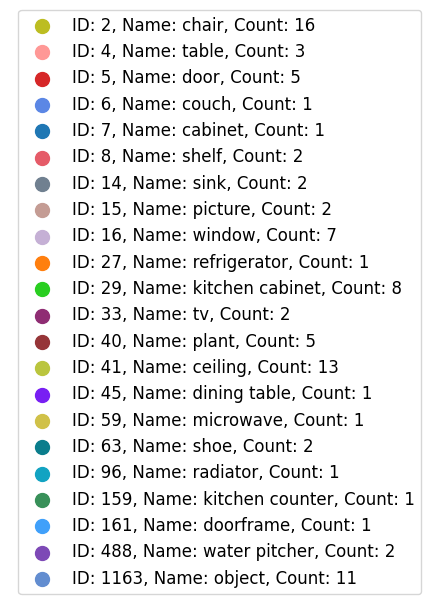

In [26]:
#
# Get the legend for objects in the scene
#

plt.figure(figsize=(0.001, len(objects) * 0.2))

# Loop over the objects and add them to the plot
for i, obj in enumerate(objects):
    object_ID = obj[0]
    count = obj[1]
    label = obj[2]
    color = [c/255 for c in obj[3]]  # normalize the color values

    plt.scatter([], [], c=[color], label=f'ID: {object_ID}, Name: {label}, Count: {count}', s=100)
    
# Create a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='large')
plt.axis('off')
plt.show()

In [27]:
# Show the segmentation with Mask3D (computed by LabelMaker)
pcd_mask3D = o3d.io.read_point_cloud(os.path.join("/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes_ORIGINAL", str(scene_id), "intermediate/scannet200_mask3d_1/mesh_labelled.ply")) # TODO TOSET: change the name of the point cloud to open
o3d.visualization.draw_geometries([pcd_mask3D])

## Labelmaker - 6. OmniData normal (used for NeuS)